In [1]:
from allensdk.core.cell_types_cache import CellTypesCache
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
np.random.seed(42)

# Produce Data

In [21]:
# Get data
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')
ephys_features = ctc.get_ephys_features()
cells = ctc.get_cells()
cells = {c['id']:c for c in cells}

# Get meta
ef_df = pd.DataFrame(ephys_features)

In [22]:
# # Format data
# meta_names = ('dendrite_type', 'disease_state', 'structure_area_abbrev', 'structure_hemisphere', 'apical', 'structure_layer_name', 'species', 'transgenic_line')
# exp, meta = [], []
# dataset = np.random.choice(ef_df['specimen_id'], 512)
# # dataset = ef_df['specimen_id']
# for sid in dataset:
#     data = ctc.get_ephys_data(sid)
#     try:
#         # Random sweeps
#         # sweep_nums = np.random.choice(data.get_experiment_sweep_numbers(), 2)
#         # sweep_nums = data.get_experiment_sweep_numbers()
        
#         # Set sweep
#         sweep_nums = 10
#         for sweep_num in sweep_nums:
#             assert sweep_num in data.get_experiment_sweep_numbers()
#     except:
#         continue
#     for sweep_num in sweep_nums:
#         sweep = data.get_sweep(sweep_num)
#         index_range = sweep["index_range"]
#         sampling_rate = sweep["sampling_rate"]
#         i = sweep["stimulus"][index_range[0]:index_range[1]+1] # in A
#         v = sweep["response"][index_range[0]:index_range[1]+1] # in V
#         i *= 1e12 # to pA
#         v *= 1e3 # to mV
#         t = np.arange(0, len(v)) * (1.0 / sampling_rate)
#         exp.append({ 'time':t, 'stim':i, 'resp':v })
#         meta.append([cells[sid][k] for k in meta_names])
# meta = np.array(meta)

In [23]:
# Format data
exp, meta = [], []
samples = 1024
sweep_num = 10
for sid in np.random.choice(np.array(ef_df['specimen_id']), samples, replace=False):
    data = ctc.get_ephys_data(sid)
    try:
        assert sweep_num in data.get_experiment_sweep_numbers()
    except:
        continue
    if cells[sid]['dendrite_type'] not in ['spiny', 'aspiny']:
        continue
    sweep = data.get_sweep(sweep_num)
    index_range = sweep["index_range"]
    sampling_rate = sweep["sampling_rate"]
    i = sweep["stimulus"][index_range[0]:index_range[1]+1] # in A
    v = sweep["response"][index_range[0]:index_range[1]+1] # in V
    i *= 1e12 # to pA
    v *= 1e3 # to mV
    t = np.arange(0, len(v)) * (1.0 / sampling_rate)
    exp.append({ 'time':t, 'stim':i, 'resp':v })
    meta.append([cells[sid][k] for k in meta_names])
meta = np.array(meta)

# Making the Model

In [16]:
import torch
from torch import nn

# https://github.com/lkulowski/LSTM_encoder_decoder
# https://github.com/lkulowski/LSTM_encoder_decoder/blob/master/code/lstm_encoder_decoder.py
# https://openreview.net/pdf?id=SygInj05Fm
# Encoder
class LSTMEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        
    def forward(self, X):
        # X: (seq_len, batch_size, input_len)
        output, hidden = self.lstm(X)
        return output, hidden
    
# Decoder
class LSTMDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, input_size)
        
    def forward(self, X, hidden_state):
        # X: (batch_size, input_len)
        output, hidden = self.lstm(X.unsqueeze(0), hidden_state)
        output = self.fc(output.squeeze(0))
        return output, hidden

# Make model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.encoder = LSTMEncoder(self.input_size, self.hidden_size, self.num_layers)
        self.decoder = LSTMDecoder(self.input_size, self.hidden_size, self.num_layers)
    
    def forward(self, X, method='teacher-forcing'):
        # X: (seq_len, batch_size, input_len)
        output_state, hidden_state = self.encoder(X)
        embedded = hidden_state[0].squeeze(0)
        
        output_state = torch.zeros_like(X[-1, :, :])
        # output_state = X[-1, :, :]  # Doesn't seem like it would help?  Need to not use this for imputation
        output = torch.zeros_like(X)
        if method == 'teacher-forcing':
            teacher_forcing_prob = .5
            for i in range(X.shape[0]):
                output_state, hidden_state = self.decoder(output_state, hidden_state)
                output[i, :, :] = output_state  # copy?
                if np.random.rand() < teacher_forcing_prob:
                    output_state = X[i, :, :]
        elif method == 'recursive':
            for i in range(X.shape[0]):
                output_state, hidden_state = self.decoder(output_state, hidden_state)
                output[i, :, :] = output_state
        else:
            raise Exception('Method not found')
        
        return embedded, output

In [17]:
# Training
epochs = 4_001
epoch_cli = 200
batch_size = 512
# LSTM-specific
window_num = 8
window_size = 64
# Latent space
hidden_size = 32
# Input data
subsampling = 100

# Create model
net = LSTMModel(2*window_size, hidden_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

for epoch in range(epochs):
    for batch in range(len(exp)//batch_size):
        # Get random sweeps
        batch_idx = np.random.choice(len(exp), batch_size)
        input_tensor = []
        for i in batch_idx:
            # Get windows
            data = exp[i]['resp'][::subsampling] # Append stim and resp on first dim asdf
            window_idx = np.random.choice(len(data) - window_num * window_size)
            input_tensor.append(torch.stack([ torch.Tensor(data)[window_idx + (j * window_size) : window_idx + ((j+1) * window_size)] for j in range(window_num) ], axis=0))
        input_tensor = torch.stack(input_tensor, axis=1)
        
        # Get outputs
        _, logits = net(input_tensor)
        true = input_tensor
        
        # Loss
        loss = criterion(logits, true)
        
        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    # CLI
    if epoch % epoch_cli == 0:
        print(f'Epoch: {epoch}  \tLoss: {float(loss.detach()):.5f}')

Epoch: 0  	Loss: 5056.33203
Epoch: 200  	Loss: 4071.91382
Epoch: 400  	Loss: 3316.22095
Epoch: 600  	Loss: 2647.59448
Epoch: 800  	Loss: 2094.20166
Epoch: 1000  	Loss: 1626.21838
Epoch: 1200  	Loss: 1332.90942
Epoch: 1400  	Loss: 1008.16895
Epoch: 1600  	Loss: 764.39600
Epoch: 1800  	Loss: 546.71814
Epoch: 2000  	Loss: 403.89099
Epoch: 2200  	Loss: 376.15668
Epoch: 2400  	Loss: 560.23761
Epoch: 2600  	Loss: 378.85971
Epoch: 2800  	Loss: 363.95288
Epoch: 3000  	Loss: 244.36940
Epoch: 3200  	Loss: 131.40408
Epoch: 3400  	Loss: 92.37495
Epoch: 3600  	Loss: 55.77102
Epoch: 3800  	Loss: 77.73515
Epoch: 4000  	Loss: 67.03992


KeyboardInterrupt: 

# Examples

In [18]:
import umap

# asdf: Better sampling method for preview
input_tensor = []
for i in range(len(exp)):
    # Get windows
    window_idx = np.random.choice(len(exp[i]['resp']) - window_num * window_size)
    input_tensor.append(torch.stack([ torch.Tensor(exp[i]['resp'])[window_idx + (j * window_size) : window_idx + ((j+1) * window_size)] for j in range(window_num) ], axis=0))
input_tensor = torch.stack(input_tensor, axis=1)
embeddings, _ = net(input_tensor)

um = umap.UMAP(n_components=2, n_neighbors=25, min_dist=.5)
um_data = um.fit_transform(embeddings.detach())

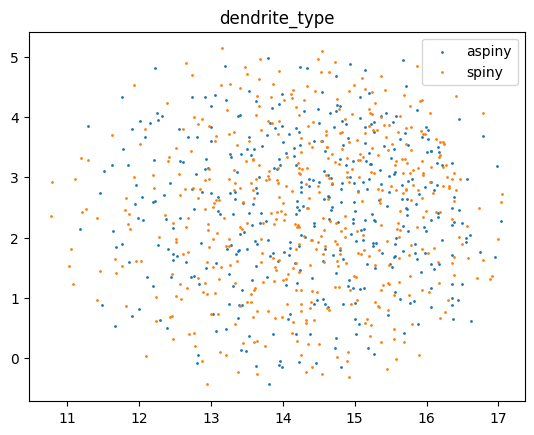

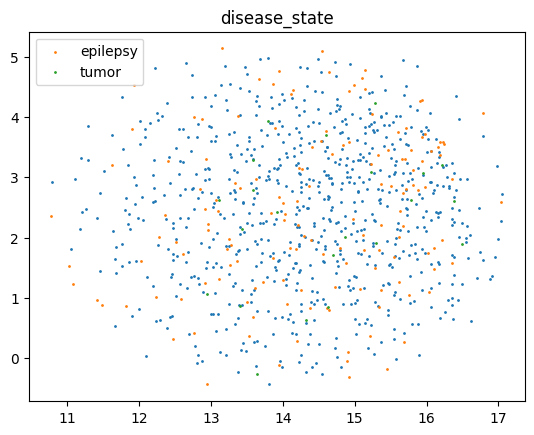

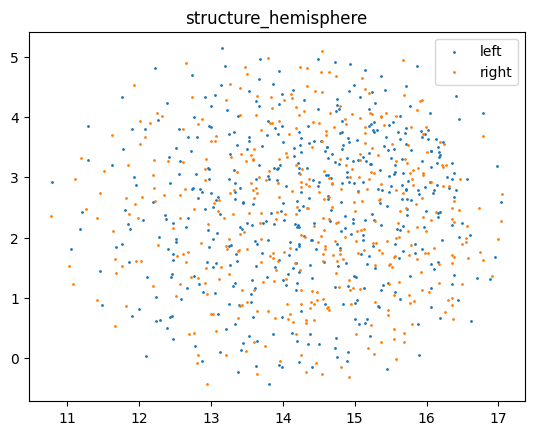

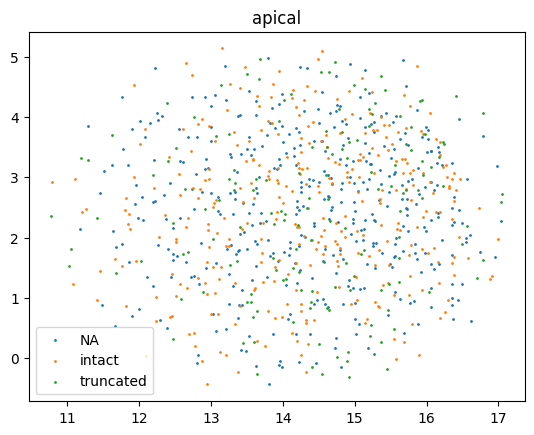

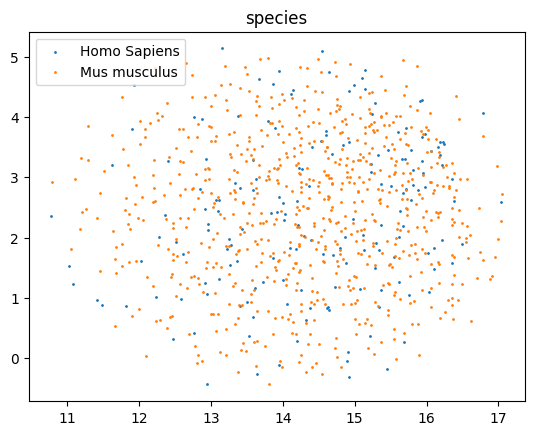

In [24]:
for i in range(len(meta[0])):
    meta_target = meta[:, i]
    if len(np.unique(meta_target)) > 7:
        continue
    plt.figure()
    for l in np.unique(meta_target):
        plt.scatter(*um_data[meta_target == l, :].T, s=1., label=l)
    plt.title(meta_names[i])
    plt.legend()